In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

In [72]:
def minigooglenet_functional(width, height, depth, classes):
	def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
		# define a CONV => BN => RELU pattern
		x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Activation("relu")(x)
		# return the block
		return x

	def inception_module(x, numK1x1, numK3x3, chanDim):
		# define two CONV modules, then concatenate across the
		# channel dimension
		conv_1x1 = conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
		conv_3x3 = conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
		x = concatenate([conv_1x1, conv_3x3], axis=chanDim)
		# return the block
		return x

	def downsample_module(x, K, chanDim):
		# define the CONV module and POOL, then concatenate
		# across the channel dimensions
		conv_3x3 = conv_module(x, K, 3, 3, (2, 2), chanDim,
			padding="valid")
		pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
		x = concatenate([conv_3x3, pool], axis=chanDim)
		# return the block
		return x

	# initialize the input shape to be "channels last" and the
	# channels dimension itself
	inputShape = (height, width, depth)
	chanDim = -1
	# define the model input and first CONV module
	inputs = Input(shape=inputShape)
	x = conv_module(inputs, 96, 3, 3, (1, 1), chanDim)
	# two Inception modules followed by a downsample module
	x = inception_module(x, 32, 32, chanDim)
	x = inception_module(x, 32, 48, chanDim)
	x = downsample_module(x, 80, chanDim)
	# four Inception modules followed by a downsample module
	x = inception_module(x, 112, 48, chanDim)
	x = inception_module(x, 96, 64, chanDim)
	x = inception_module(x, 80, 80, chanDim)
	x = inception_module(x, 48, 96, chanDim)
	x = downsample_module(x, 96, chanDim)
	# two Inception modules followed by global POOL and dropout
	x = inception_module(x, 176, 160, chanDim)
	x = inception_module(x, 176, 160, chanDim)
	x = GlobalAveragePooling2D()(x)
	# x = Dropout(0.5)(x)
	# softmax classifier
	x = Flatten()(x)
	x = Dense(classes)(x)
	x = Activation("softmax")(x)
	# create the model
	model = Model(inputs, x, name="minigooglenet")
	# return the constructed network architecture
	return model

In [73]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# there seems to be an issue with TensorFlow 2.0 throwing non-critical
# warnings regarding gradients when using the model sub-classing
# feature -- I found that by setting the logging level I can suppress
# the warnings from showing up (likely won't be required in future
# releases of TensorFlow)
import logging
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import argparse

In [74]:
# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-2
BATCH_SIZE = 128
NUM_EPOCHS = 20
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog",
	"frog", "horse", "ship", "truck"]
# load the CIFAR-10 dataset
print("[INFO] loading CIFAR-10 dataset...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
# scale the data to the range [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=18, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	 horizontal_flip=True, fill_mode="nearest")

[INFO] loading CIFAR-10 dataset...


In [75]:
	print("[INFO] using model sub-classing...")
	model = minigooglenet_functional(32, 32, 3, len(labelNames))

[INFO] using model sub-classing...


In [76]:
# initialize the optimizer and compile the model
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
print("[INFO] training network...")
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the network
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

[INFO] training network...
Epoch 1/20
390/390 [==============================] - 35s 91ms/step - loss: 1.6091 - accuracy: 0.4120 - val_loss: 1.8461 - val_accuracy: 0.3605
Epoch 2/20
390/390 [==============================] - 35s 90ms/step - loss: 1.2364 - accuracy: 0.5582 - val_loss: 1.3284 - val_accuracy: 0.5441
Epoch 3/20
390/390 [==============================] - 36s 92ms/step - loss: 1.0661 - accuracy: 0.6246 - val_loss: 1.0824 - val_accuracy: 0.6111
Epoch 4/20
390/390 [==============================] - 36s 92ms/step - loss: 0.9686 - accuracy: 0.6588 - val_loss: 1.5051 - val_accuracy: 0.5625
Epoch 5/20
390/390 [==============================] - 35s 90ms/step - loss: 0.8923 - accuracy: 0.6882 - val_loss: 1.3028 - val_accuracy: 0.6011
Epoch 6/20
390/390 [==============================] - 35s 91ms/step - loss: 0.8325 - accuracy: 0.7108 - val_loss: 1.1577 - val_accuracy: 0.6377
Epoch 7/20
390/390 [==============================] - 36s 91ms/step - loss: 0.7801 - accuracy: 0.7277 - val_l

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.80      0.88      0.84      1000
  automobile       0.92      0.93      0.92      1000
        bird       0.61      0.81      0.70      1000
         cat       0.84      0.47      0.60      1000
        deer       0.81      0.70      0.75      1000
         dog       0.89      0.55      0.68      1000
        frog       0.57      0.96      0.71      1000
       horse       0.91      0.77      0.83      1000
        ship       0.93      0.90      0.91      1000
       truck       0.87      0.89      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.78     10000
weighted avg       0.81      0.79      0.78     10000



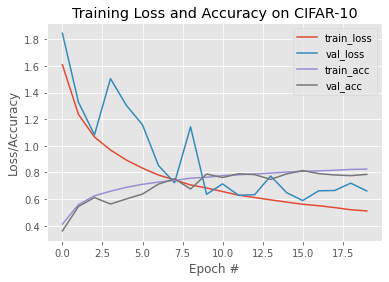

In [77]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))
# determine the number of epochs and then construct the plot title
N = np.arange(0, NUM_EPOCHS)
title = "Training Loss and Accuracy on CIFAR-10"
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("res.png")

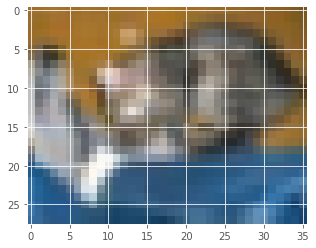

In [130]:
from matplotlib import pyplot as plt
%matplotlib inline
first_image = cv2.resize(testX[0], (36, 28))
second_image = cv2.resize(testX[1], (36, 28))
third_image = cv2.resize(testX[2], (36, 28))
cv2.imwrite("first.png", first_image)
cv2.imwrite("second.png", second_image)
cv2.imwrite("third.png", third_image)
images = np.array([first_image, second_image, third_image])

plt.imshow(first_image, interpolation='nearest')
plt.show()

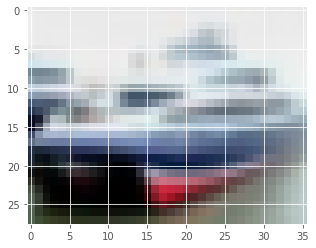

In [126]:
plt.imshow(second_image, interpolation='nearest')
plt.show()

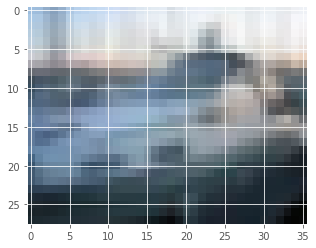

In [127]:
plt.imshow(third_image, interpolation='nearest')
plt.show()

In [131]:
model.predict(images[0:3], batch_size=3)

array([[2.2213054e-03, 4.9848517e-04, 5.4269809e-02, 7.6645792e-01,
        4.1359249e-03, 8.4563777e-02, 8.5475184e-02, 2.8893116e-04,
        2.0183269e-03, 7.0387461e-05],
       [2.2637725e-04, 4.8231077e-03, 5.3465925e-07, 7.8117046e-07,
        7.5678048e-07, 1.0489500e-07, 4.1742163e-07, 4.2542769e-07,
        9.9493068e-01, 1.6869542e-05],
       [1.3003650e-04, 1.5998476e-03, 4.7704198e-06, 5.6204240e-06,
        1.6715107e-05, 3.3022798e-07, 8.1673528e-07, 5.4216730e-07,
        9.9821281e-01, 2.8588582e-05]], dtype=float32)

In [132]:
model.predict(images[0:3], batch_size=3).argmax(axis=1)

array([3, 8, 8])